#### The purpose is this notebook to convert the relation data (domain, pages, email, bitcoin address, domain-links, page-links, email-links, bitcoin address-link)  to the form of a  heterogeneous graph.


In [ ]:
#import the module
%matplotlib inline
import MySQLdb as mariadb
import pandas as pd
import hashlib

from elasticsearch import Elasticsearch
from elasticsearch_dsl import Search
from elasticsearch_dsl import Q

from tqdm.notebook import tqdm

db_host = 'd-spider-db'
db_user = 'torscraper'
db_password = 'password'
db = 'tor'

In [2]:
#Connect to database
def query_execute(query): 
    conn = mariadb.connect(db_host, db_user, db_password, db, use_unicode=True, charset="utf8");
    domain_data = pd.io.sql.read_sql(query, conn)
    conn.close()
    domain_data = domain_data.drop_duplicates(ignore_index=True)
    return domain_data

In [3]:
#read bitcoin address data
bitcoin_address =  query_execute('select * from bitcoin_address limit 100;')

#read bitcoin address links (bitcoin address - to - bitcoin address connections)
bitcoin_address_link =  query_execute('select * from bitcoin_address_link limit 100;')

#read domain data
domain =  query_execute('select * from domain limit 100;')

#read email data
email =  query_execute('select * from email limit 100;')

#read email link data (email - to - email connections)
email_link =  query_execute('select * from email_link limit 100;')

#read page data
page =  query_execute('select * from page limit 100;')

#read page link data (page - to - page connections)
page_link =  query_execute('select * from page_link limit 100;')

In [4]:
#import networkX module
import networkx as nx

#init GraphX object
G = nx.Graph()

In [5]:
#view head of the data frame (bitcoin_address)
bitcoin_address.head(1)

,id,address
0,93621,1111AjKts3rxSrWNUZAS76zrY8ENsG59q


In [6]:
#insert bitcoin address nodes

for index, row in tqdm(bitcoin_address.iterrows()):
    G.add_node('b{}'.format(row.id), label='b')

In [7]:
#view head of the data frame (page)

page.head(1)

,id,url,title,code,domain,created_at,visited_at,is_frontpage,size,path
0,14817765,http://vfgop7uag7dpxuxq.onion/,The Pot Shop – Best Pot Ever,504,304845,2020-04-17 07:43:31,2020-06-22 04:24:01,1,93,/


In [8]:
#insert pages

for index, row in tqdm(page.iterrows()):
    G.add_node('p{}'.format(row.id), label='p')

In [9]:
#view head of the data frame (domain)

domain.head(1)

,id,host,port,ssl,is_up,created_at,visited_at,title,last_alive,is_crap,...,useful_404_php,useful_404_dir,clone_group,new_clone_group,ban_exempt,manual_genuine,language,description_json,description_json_at,whatweb_at
0,304845,vfgop7uag7dpxuxq.onion,80,0,0,2020-04-17 07:43:31,2020-06-22 04:24:01,The Pot Shop – Best Pot Ever,2020-06-02 06:50:56,0,...,1,0,None,None,0,0,,null,2020-05-28 01:50:52,1970-01-01


In [10]:
#insert doain

for index, row in tqdm(domain.iterrows()):
    G.add_node('d{}'.format(row.id), label='domain')

In [11]:
#view head of the data frame (email)


email.head(1)

,id,address
0,130119,+-gpuepfqorbywdwm-eo4egbrcnttxovs4a@mail.gmail...


In [12]:
#insert emails

for index, row in tqdm(email.iterrows()):
    G.add_node('e{}'.format(row.id), label='domain')

In [13]:
#insert page - bitcoin addres edges

for index, row in tqdm(bitcoin_address_link.iterrows()):
    G.add_edge('b{}'.format(row.bitcoin_address), 'p{}'.format(row.page), label='p2b' )

In [14]:
#insert page - domain address edges

for index, row in tqdm(page.iterrows()):
    G.add_edge('p{}'.format(row.id), 'd{}'.format(row.domain), label='p2d' )

In [15]:
#insert page - email address edges

for index, row in tqdm(email_link.iterrows()):
    G.add_edge('e{}'.format(row.email), 'p{}'.format(row.page), label='e2p' )

In [16]:
#insert page - page edges

for index, row in tqdm(page_link.iterrows()):
    G.add_edge('p{}'.format(row.link_from), 'p{}'.format(row.link_to), label='p2p' )

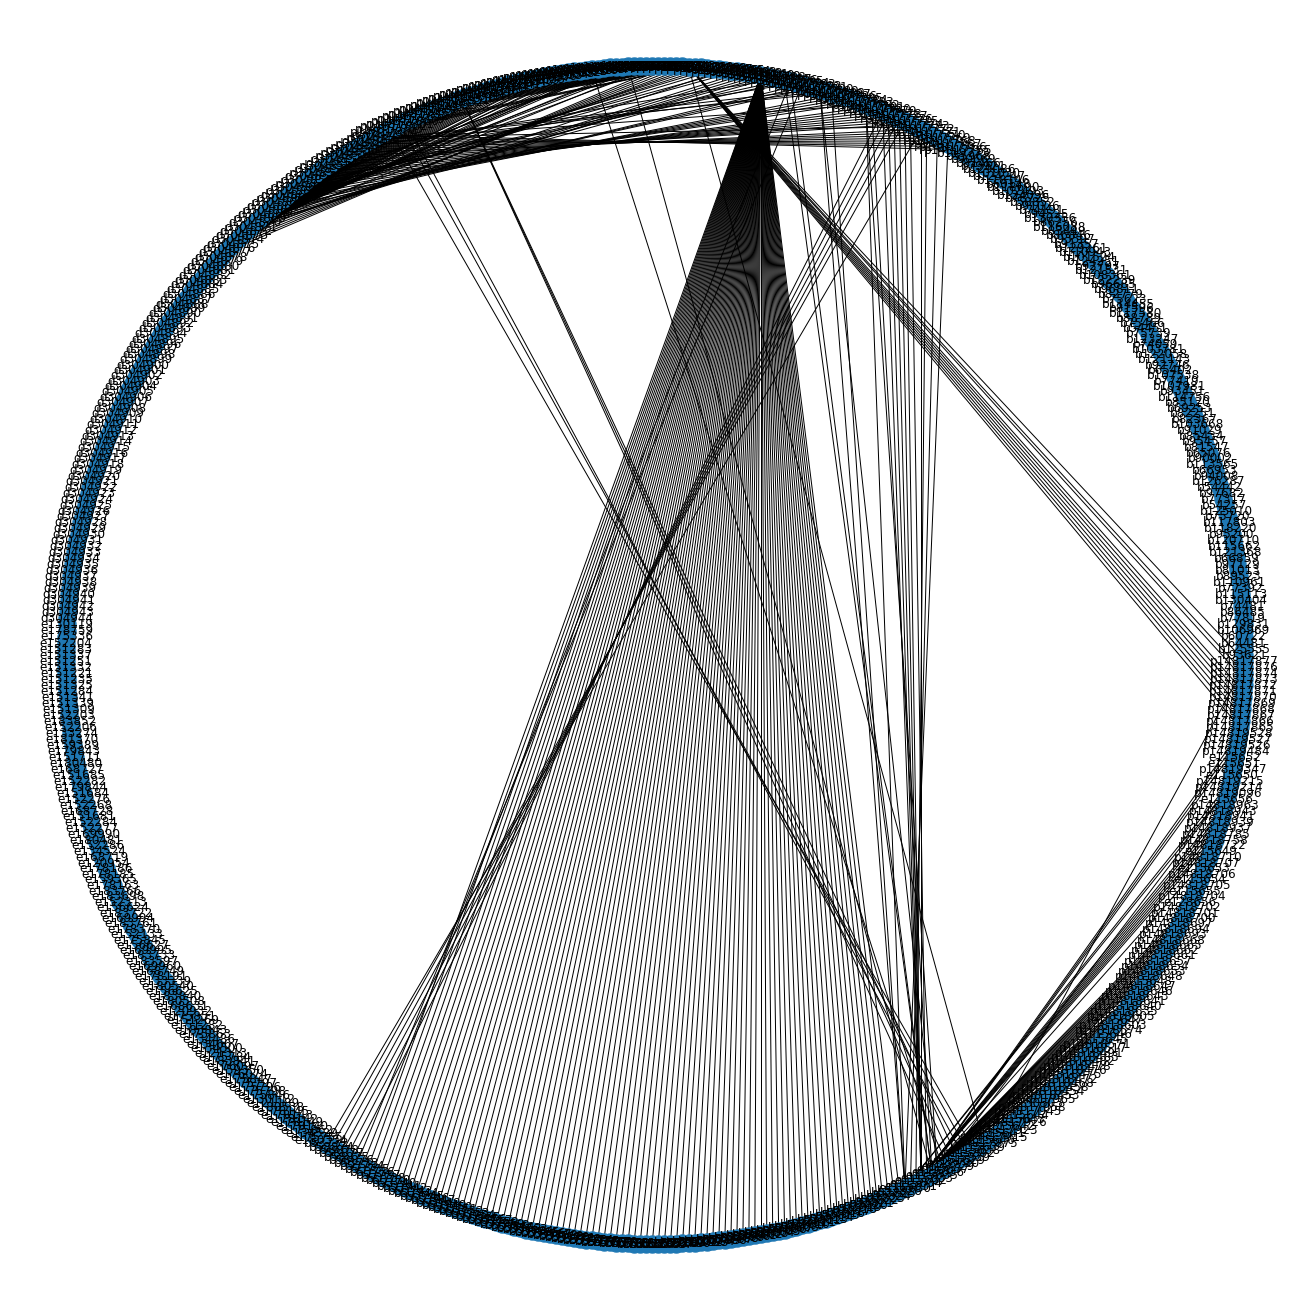

In [17]:
import scipy
from matplotlib import pyplot as plt
plt.figure(3,figsize=(18,18)) 
pos = nx.circular_layout(G)
nx.draw(G, pos, with_labels=True)
plt.show()

In [18]:
#maximum digree
print(max(dict(G.degree()).items(), key = lambda x : x[1]))
#minium digree
print(min(dict(G.degree()).items(), key = lambda x : x[1]))

('p14817800', 96)
('b93621', 0)
